In [1]:
{-# LANGUAGE LambdaCase
    , RecordWildCards
    , TemplateHaskell
    , ScopedTypeVariables
    , RankNTypes
    , BangPatterns
    , StandaloneDeriving
    , UndecidableInstances
    , DataKinds
    , BlockArguments
    , KindSignatures
    , MagicHash
    , ConstraintKinds
    , FlexibleContexts #-}

Line 1: Unused LANGUAGE pragma
Found:
{-# LANGUAGE LambdaCase, RecordWildCards, TemplateHaskell, ScopedTypeVariables, RankNTypes, BangPatterns, StandaloneDeriving, UndecidableInstances, DataKinds, BlockArguments, KindSignatures, MagicHash, ConstraintKinds, FlexibleContexts #-}
Why not:
{-# LANGUAGE ScopedTypeVariables, RankNTypes, UndecidableInstances, DataKinds, BlockArguments, ConstraintKinds, FlexibleContexts #-}

In [2]:
import Graphics.Matplotlib
import IHaskell.Display
import qualified Data.Map as Map
import Data.Map (Map)
import qualified Data.Csv as CSV
import qualified Data.ByteString.Lazy as BL
import qualified Data.Vector as Vec
import qualified Data.Vector.Unboxed as UVec
import qualified Data.Vector.Generic as GVec
import qualified Linear.V as V
import qualified Data.Vector.Algorithms.Intro as VecAlgI
import Data.Functor
import Data.Foldable
import Data.Function
import Data.Maybe
import Control.Monad.Identity
import qualified Control.Parallel.Strategies as Par
import qualified Data.Sequence as Seq
import Control.Monad
import qualified Statistics.Function as StatF
import Control.Lens
import qualified Statistics.Sample.Normalize as Stat
import qualified Statistics.Sample as Stat
import qualified Statistics.Function as Stat
import qualified Data.List as List
import GHC.TypeLits (Nat, KnownNat, natVal')
import GHC.Exts (Proxy#, proxy#)
import Data.Traversable
import GHC.Stack
import System.IO.Unsafe
import System.Random
import Control.DeepSeq
import qualified IHaskell.Display as Display
import Control.Monad.Trans.Reader
import qualified Data.Aeson as Aeson

import qualified System.Random.Shuffle

In [3]:
putPlot :: Matplotlib -> IO DisplayData
putPlot p = do
    pic <- toSvg p
    return $ either error id (svg <$> pic)

In [4]:
shuffleVector :: GVec.Vector v a => v a -> IO (v a)

shuffleVector x = GVec.fromList  <$> System.Random.Shuffle.shuffleM (GVec.toList x)

In [5]:
type XsE = UVec.Vector Double
type Xs = Vec.Vector XsE
type YsE = Int
type Ys = UVec.Vector YsE

castTD :: (Double, Double, String) -> (XsE, String)
castTD (x, y, clazz) = (UVec.fromList [x, y], clazz)

dfInit <- BL.readFile "../3/geyser.csv"
    <&> CSV.decode CSV.HasHeader
    <&> either error id
    <&> fmap castTD
xsAll :: Xs
xsAll = dfInit <&> fst
ys0All = dfInit <&> snd
clazzes = Map.fromList $ zip (List.nub $ List.sort $ Vec.toList $ ys0All) $ [-1] ++ [1..]
ysAll :: Ys
ysAll = UVec.fromList $ Vec.toList $ ys0All <&> (clazzes Map.!)

In [6]:
n = GVec.length $ GVec.head xsAll
print n
print $ GVec.length xsAll

2

222

In [7]:
splitTrainTest :: Xs -> Ys -> IO ((Xs, Ys), (Xs, Ys))
splitTrainTest xs ys = do
    vec <- shuffleVector $ GVec.zip xs (GVec.convert ys)
    let trainSize = ceiling $ fromIntegral (GVec.length vec) * 0.8
    return
        ( GVec.unzip (GVec.take trainSize vec) <&> GVec.convert
        , GVec.unzip (GVec.drop trainSize vec) <&> GVec.convert
        )

In [8]:
((xsTrain, ysTrain), (xsTest, ysTest)) <- splitTrainTest xsAll ysAll

In [9]:
data Dataset
    = Dataset
        { dxs :: Xs
        , dys :: Ys
        , dweights :: UVec.Vector Double }
    deriving (Show)

In [10]:
features :: Reader Dataset (Vec.Vector (XsE -> Bool))
features = do
    xs <- reader dxs
    let xs' = [0..n-1] <&> \i -> xs <&> (UVec.! i)
    return $
        Vec.fromList [0..n-1] >>= \ !i ->
            Vec.uniq (Vec.modify VecAlgI.sort $ xs' !! i) <&> \ !x ->
                \ !obj -> obj UVec.! i <= x

Line 7: Collapse lambdas
Found:
\ !x -> \ !obj -> obj UVec.! i <= x
Why not:
\ !x !obj -> obj UVec.! i <= x

In [11]:
dbg a = unsafePerformIO (print a >> return a)

In [12]:
getCounts :: GVec.Vector v Int => v Int -> Reader Dataset (Map Int Int)
getCounts ind = do
    ys <- reader dys
    return $ GVec.foldl'
        (\m k -> Map.insertWith (+) k 1 m)
        Map.empty
        (GVec.map (ys UVec.!) ind)

entropy :: UVec.Vector Int -> Reader Dataset Double
entropy ve = do
    cnts <- getCounts ve
    return $ negate $ sum
        [ p * log p
        | x <- toList cnts
        , let p = x /~ UVec.length ve
        ]

data Tree
    = TBinary !(UVec.Vector Double -> Bool) !Tree !Tree
    | TLeaf !Int !Double

instance Show Tree where
    show (TBinary _ l r) = "(" ++ show l ++ " ; " ++ show r ++ ")"
    show (TLeaf i d) = show i ++ "[" ++ show d ++ "]"

class Predict a where
    predict :: a -> UVec.Vector Double -> (Double, Int)

instance Predict Tree where
    predict (TBinary f l r) !v =
        predict
            (if f v
             then l
             else r)
            v
    predict (TLeaf a d) _ = (d, a)

finalize :: UVec.Vector Int -> Reader Dataset Tree
finalize v = do
    cnts <- getCounts v
    let mx = maximumBy (compare `on` snd) $ Map.toList cnts
    return $ TLeaf (fst mx) (snd mx /~ GVec.length v)

allSame :: (Eq a, UVec.Unbox a) => UVec.Vector a -> Bool
allSame t =
    isJust $ UVec.foldr
        (\v a ->
            join $ a <&> \a -> if v == a then Just v else Nothing)
        (Just $ UVec.head t) t

infixl 7 /~

(/~) :: Integral a => a -> a -> Double
(/~) = (/) `on` fromIntegral

In [13]:
buildTree
    :: (Int -> Bool)
    -> Vec.Vector (XsE -> Bool)
    -> UVec.Vector Int
    -> Int
    -> Reader Dataset Tree
buildTree !exceeded !features !objects !iter = do
    -- let !dbg = unsafePerformIO (print objects) in
    xs <- reader dxs
    ys <- reader dys
    w <- reader dweights
    let my = UVec.map (ys UVec.!) objects
    if Vec.null features || exceeded iter || allSame my
    then finalize objects
    else do
        let
            mapW o = GVec.sum (GVec.map (w GVec.!) o)
            olen = mapW objects
            calcEntArg s = do
                e <- entropy s
                return $ mapW s / olen * e
        uv <- forM features \feature -> do
            let prt = objects & UVec.partition (\i -> feature $ xs Vec.! i)
            !lft <- uncurry (liftM2 (+) `on` calcEntArg) prt
            return (lft, prt)
        let
            ind = minimumBy (compare `on` \i -> fst $ uv Vec.! i)  [0..Vec.length uv - 1]
            indBad i = UVec.length (fst $ snd $ uv Vec.! i) `elem` [0, GVec.length objects]
            subFeatures = Vec.ifilter (\i _ -> i /= ind && not (indBad i)) features
            makeAns f =
                buildTree
                    exceeded
                    subFeatures
                    (f $ snd $ uv Vec.! ind)
                    (iter + 1)
        if indBad ind
        then buildTree exceeded subFeatures objects iter
        else do
            f <- makeAns fst
            s <- makeAns snd
            return $ TBinary (features Vec.! ind) f s

In [14]:
accuracy :: (GVec.Vector v Int, GVec.Vector v Bool) => v Int -> v Int -> Double
accuracy a b =
    if GVec.length a == GVec.length b
    then
        let s = GVec.sum $ (\i -> if i then 1 else 0) `GVec.map` GVec.zipWith (==) a b in
        s /~ GVec.length a
    else error "wrong len"

In [15]:
testAll
    :: Predict p
    => Xs -- ^ tain
    -> Ys -- ^ tain
    -> Xs -- ^ test
    -> Ys -- ^ test
    -> (Vec.Vector (XsE -> Bool) -> UVec.Vector Int -> Reader Dataset p)
    -> IO Double
testAll trainX trainY testX testY builder = do
    let
        datas = Dataset trainX trainY $ UVec.replicate (GVec.length trainX) 1
        feat0 :: Vec.Vector (XsE -> Bool)
        feat0 = runReader features datas
    feat <- shuffleVector feat0
    let
        !reslt =
            runReader
                (builder feat $ UVec.fromList [0..GVec.length trainX - 1])
                datas
        !tested = testX <&> predict reslt & toList & UVec.fromList
        xmi = minimum $ testX <> trainX <&> (GVec.! 0)
        xma = maximum $ testX <> trainX <&> (GVec.! 0)
        ymi = minimum $ testX <> trainX <&> (GVec.! 1)
        yma = maximum $ testX <> trainX <&> (GVec.! 1)
        dx = (xma - xmi) / 30
        dy = (yma - ymi) / 30
        xr = [xmi, xmi + dx .. xma]
        yr = [ymi, ymi + dy .. yma]
        pri = 
            [ [ (\(a, b) -> a * fromIntegral b) $ predict reslt $ UVec.fromList [x, y]
                | x <- xr
              ]
            | y <- yr
            ]
    Display.printDisplay $ putPlot $
        pcolor3 xr yr pri
        % scatter (trainX <&> (UVec.! 0)) (trainX <&> (UVec.! 1))
            @@ [o2 "c" $ UVec.toList trainY, o2 "linewidths" 1, o2 "edgecolors" "black", o2 "s" 6]
        % scatter (testX <&> (UVec.! 0)) (testX <&> (UVec.! 1))
            @@ [o2 "c" $ UVec.toList testY, o2 "linewidths" 2, o2 "edgecolors" "black"]
    let accu = accuracy (UVec.map snd tested) testY
    Display.printDisplay $ plain $ "accuracy: " ++ show accu
    return accu

In [16]:
testAllSane = testAll xsTrain ysTrain xsTest ysTest

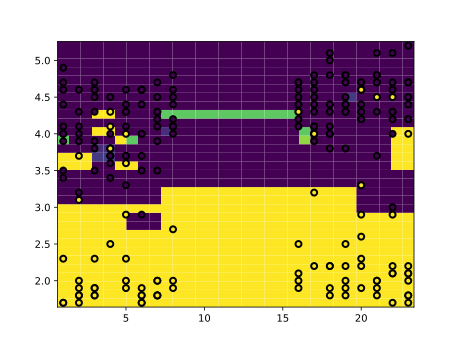

accuracy: 0.954954954954955

In [17]:
void $ testAll xsAll ysAll xsAll ysAll $ \f o -> buildTree (const False) f o 0

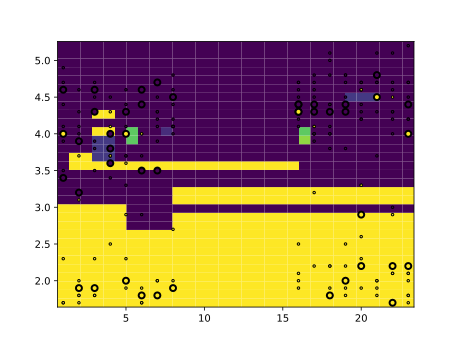

accuracy: 0.8636363636363636

In [18]:
void $ testAllSane \f o -> buildTree (const False) f o 0

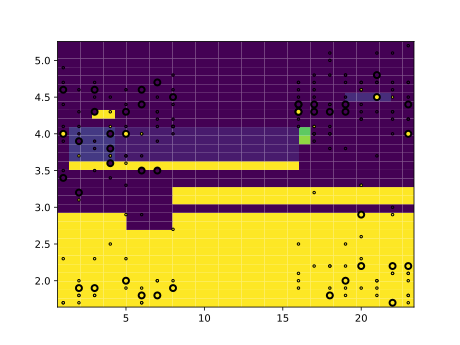

accuracy: 0.8863636363636364

In [19]:
void $ testAllSane \f o -> buildTree (> 7) f o 0

Вероятность 100% на наборе на которм обучали это хорошо
# Random

In [20]:
rolls :: RandomGen g => Int -> g -> [Int]
rolls n = List.unfoldr (Just . uniformR (0, n - 1))

In [21]:
rnd :: IO [Int]
rnd = newStdGen <&> take 10 . rolls 4
rnd

[3,2,0,3,3,3,2,2,3,2]

In [22]:
newtype Forest = Forest (Vec.Vector Tree) deriving (Show)
instance Predict Forest where
    predict (Forest frst) v =
        frst <&> flip predict v & \res ->
            let
                asMap = Map.toList $
                    foldl'
                        (\m k -> Map.insertWith (+) k 1 m)
                        Map.empty
                        (snd <$> res)
            in (\(clazz, cnt) -> (cnt /~ GVec.length frst, clazz)) $ maximumBy (compare `on` snd) asMap

buildRandomTrees :: Int -> Vec.Vector (UVec.Vector Double -> Bool) -> UVec.Vector Int -> IO (Reader Dataset Forest)
buildRandomTrees count f o = do
    let n = GVec.length o
    let m = floor $ sqrt $ fromIntegral $ GVec.length f
    res <- forM (Vec.fromList [0..count]) \i -> do
        !objs <- newStdGen <&> take n . rolls n <&> fmap (o GVec.!) <&> UVec.fromList
        !feat <- newStdGen <&> take m . rolls (GVec.length f) <&> fmap (f GVec.!) <&> Vec.fromList
        return $ buildTree (const False) feat objs 0
    return $ Forest <$> sequence res

0.8636363636363636

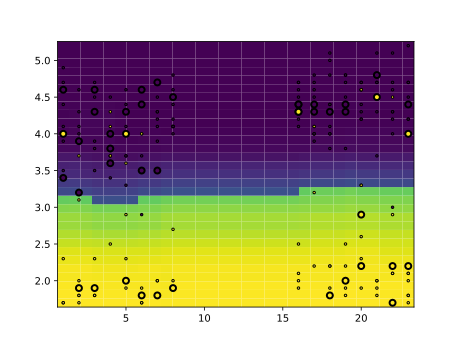

accuracy: 0.8636363636363636

In [23]:
testAllSane \f o -> unsafePerformIO $ buildRandomTrees 200 f o

# Ada

In [24]:
makeLensesFor [("dweights", "dweightsL")] ''Dataset

In [33]:
newtype FPredict = FPredict (UVec.Vector Double -> (Double, Int))

instance Predict FPredict where
    predict (FPredict f) = f

type Summator = UVec.Vector Double -> Map Int Double

buildAda ::  Vec.Vector (UVec.Vector Double -> Bool) -> UVec.Vector Int -> Reader Dataset [Summator]
buildAda f o = do
    xs <- reader dxs
    ys <- reader dys
    let
        bld :: Reader Dataset [Summator]
        bld = do
            weights <- reader dweights
            let
                {-# NOINLINE o' #-}
                !o' =
                    GVec.take
                        (ceiling $ 0.8 * fromIntegral (GVec.length o))
                        (unsafePerformIO $ shuffleVector o)
            !tree <- buildTree (> 2) f o' 0
            let !pre = xs <&> predict tree
            let
                preClazz :: UVec.Vector Int
                !preClazz = pre <&> snd & GVec.convert
                !preClazzW = (pre <&> \(d, i) -> fromIntegral i) & GVec.convert
            let
                e :: Double
                !e =
                    foldl'
                        (\a i -> a + if ys GVec.! i /= preClazz GVec.! i then weights GVec.! i else 0)
                        0
                        [0..Vec.length xs-1]
            let !bt = 0.5 * log ((1 - e) / e)
            let
                !wn =
                    GVec.zipWith (*)
                        weights
                        (GVec.zipWith
                            (\y c -> exp $ negate $ bt * fromIntegral y * c)
                            ys
                            preClazzW)
            let !swn = GVec.sum wn
            let !wn' = (/ swn) `GVec.map` wn
            nxt <- local (dweightsL .~ wn') bld
            return $ (\v -> predict tree v & snd & flip Map.singleton bt) : nxt
    local (dweightsL .~ UVec.replicate (Vec.length xs) (1 /~ Vec.length xs)) bld

In [34]:
 myAda <- do
    let
        datas = Dataset xsTrain ysTrain $ UVec.replicate (GVec.length xsTrain - 1) 1
        feat0 = runReader features datas
    feat <- shuffleVector feat0
    return $ runReader (buildAda feat (GVec.fromList [0..GVec.length xsTrain - 1])) datas
:t  myAda

myAda :: [Summator]

In [35]:
adaTest ttt _f _o = do
    return $ FPredict $ \v ->
        let
            mp = Map.toList $ foldl' (Map.unionWith (+)) Map.empty (take ttt myAda <&> ($ v))
            (i, d) = List.maximumBy (compare `on` snd) mp
        in (d / sum (mp <&> snd), i)

1

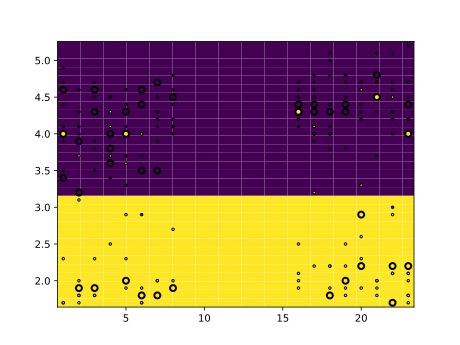

accuracy: 0.8636363636363636

2

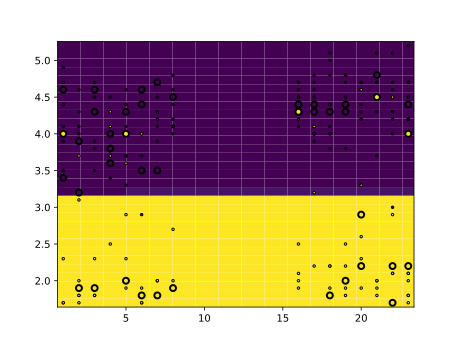

accuracy: 0.8636363636363636

3

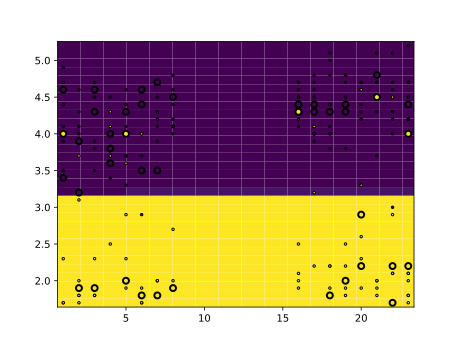

accuracy: 0.8636363636363636

5

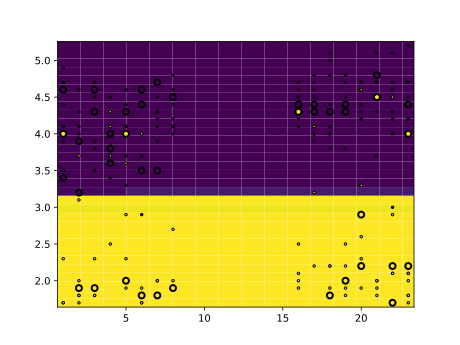

accuracy: 0.8636363636363636

8

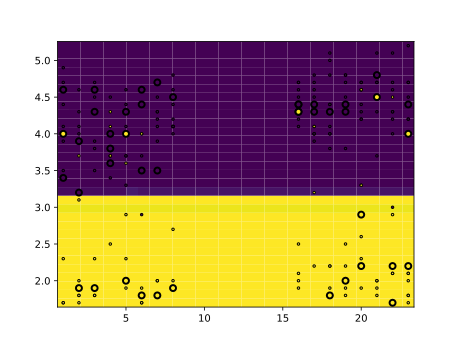

accuracy: 0.8636363636363636

13

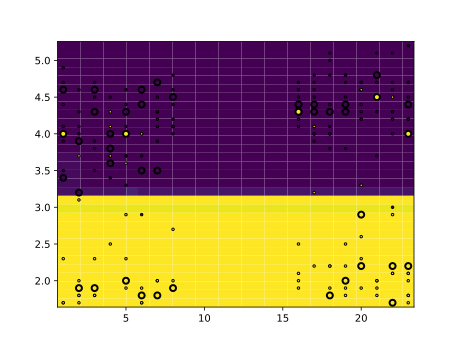

accuracy: 0.8636363636363636

21

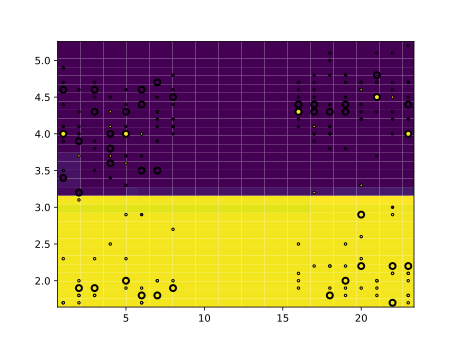

accuracy: 0.8636363636363636

34

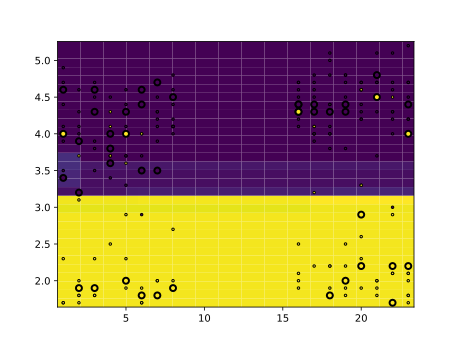

accuracy: 0.8636363636363636

55

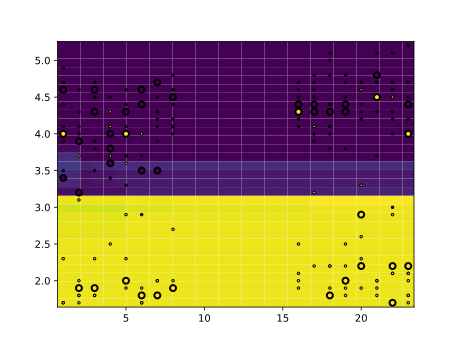

accuracy: 0.8636363636363636

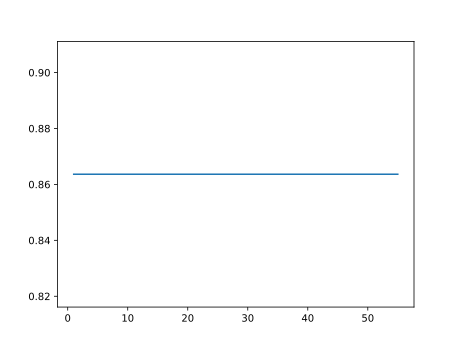

In [36]:
-- testAdaOn = [20] :: [Int]
testAdaOn = [1, 2, 3, 5, 8, 13, 21, 34, 55] :: [Int]
accsAda <- forM testAdaOn \ttt -> do
    Display.printDisplay $ plain $ show ttt
    testAllSane $ adaTest ttt
putPlot $ plot testAdaOn accsAda